---
# Calculating the recovery rate from a bleach-chase data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from roux.lib.sys import makedirs
from roux.lib.io import read_table,to_table
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure',figsize = (3, 3))

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
input_dir_path='bleach_chase/input/'
output_dir_path='bleach_chase/'
image_segmented_path='image_segmented_cells.npy'
time_bleach=3 ## time point of bleach 
force=False
test=False

**Demo data**  

In [3]:
from htsimaging.lib.io import read_image
image_intensity=read_image('image_intensity_cells.npy')

background_coff=np.quantile(image_intensity,0.5)
if test: print(background_coff)

## background
a0=image_intensity.copy()
a0[a0>background_coff]=0

makedirs(input_dir_path)
d={}
# for t,scale in enumerate([1,1,1,0.6,0.7,0.8,0.875,0.92,0.95,0.975,0.98,0.985,0.9877,0.988,0.989,0.99,0.99,0.99,0.99,0.99,0.99,0.99]):
for t,scale in enumerate([1,1,1,0.6,0.65,0.685,0.765,0.82,0.875,0.925,0.955,0.9675,0.975,0.978,0.982,0.989,0.9899,0.99,0.99,0.99,0.99,0.99]):
    a1=image_intensity*scale
    # remove the backgroud
    a1[a1<background_coff]=0
    # put back the original background    
    a1=a1+a0
    d[(t,scale)]=np.median(a1.ravel())
    np.save(f"{output_dir_path}/input/{t:02}.npy",a1)
if test:
    pd.Series(d).to_frame('intensity').rename_axis(['time','scale'],axis=0).reset_index().plot(x='time',y='intensity')

## Single-cell abundance

In [4]:
from glob import glob
parameters_list=[dict(
    ## parameters
        input_path=input_path,
        segmented_image_path='image_segmented_cells.npy',
        output_path=input_path.replace('/input/','/01_sc_abundance/').replace('.npy','.tsv'),
        misaligned_fraction_max=0.9,
        edge_off=20,
    ) for input_path in glob(input_dir_path+'/*.npy')]
parameters_list[0]

{'input_path': 'bleach_chase/input/00.npy',
 'segmented_image_path': 'image_segmented_cells.npy',
 'output_path': 'bleach_chase/01_sc_abundance/00.tsv',
 'misaligned_fraction_max': 0.9,
 'edge_off': 20}

In [5]:
from roux.workflow.task import run_tasks
output_paths=run_tasks(
    input_notebook_path='protein_abundance_and_normalization.ipynb',
    kernel='htsimaging_dev',
    parameters_list=parameters_list,
    # test1=True,
    fast=True,
    force=force,
)

0it [00:00, ?it/s]

### Outputs

In [6]:
## collect the outputs
df01=read_table(
    [d['output_path'] for d in parameters_list],
    drop_index=False,
    colindex='time',
    replaces_index=lambda x: int(Path(x).stem),
    )
df01.head(1)

  0%|          | 0/23 [00:00<?, ?it/s]

,time,cell id,abundance,abundance normalized
0,0,1,139.770998,0.993611


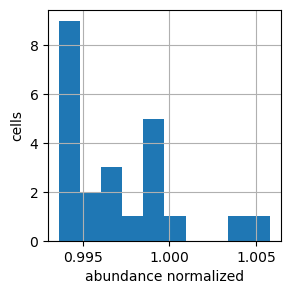

In [7]:
_=df01.query("`cell id` == 1")['abundance normalized'].hist().set(xlabel='abundance normalized',ylabel='cells')

[Text(0.5, 1.0, 'Raw kinetics')]

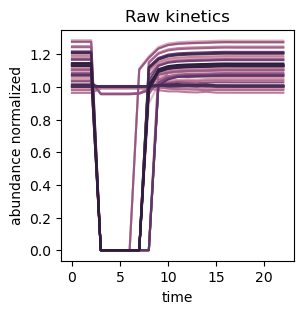

In [8]:
sns.lineplot(
    data=df01,
    x='time',
    y='abundance normalized',
    estimator='mean',
    errorbar='sd',
    hue='cell id',
    legend=False, 
).set(title='Raw kinetics')

## Processing kinetics to calculate the rate of recovery
### Rescale between the high and low abundance

In [9]:
def rescale(a,mn,mx): 
    # assert mn<mx, (mn,mx)
    # print(mn,mx)
    return (a-mn)/(mx-mn)
df1=df01.groupby('cell id',as_index=False).apply(lambda df: df.assign(
    **{'abundance rescaled': lambda df_: rescale(
    df_['abundance normalized'],
    mn=df_.query(f"`time` == {time_bleach}")['abundance normalized'].tolist()[0],
    mx=df_.query(f"`time` < {time_bleach}")['abundance normalized'].mean(),
    )
    })).reset_index(drop=True)
df1.head(1)

,time,cell id,abundance,abundance normalized,abundance rescaled
0,0,1,139.770998,0.993611,1.0


In [10]:
## filter out anomalies
df2=df1.groupby('cell id',as_index=False).filter(lambda df: all(df['abundance rescaled']>=0) and all(df['abundance rescaled']<=1) ).reset_index(drop=True)
df2.head(1)

,time,cell id,abundance,abundance normalized,abundance rescaled
0,0,2,158.973676,1.13012,1.0


[Text(0.5, 1.0, 'Rescaled kinetics')]

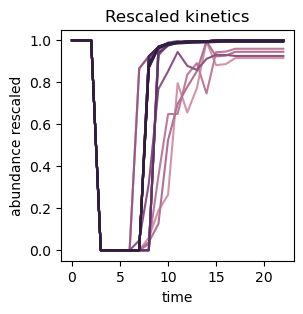

In [11]:
sns.lineplot(
    data=df2,
    x='time',
    y='abundance rescaled',
    estimator='mean',
    errorbar='sd',
    hue='cell id',
    legend=False, 
).set(title='Rescaled kinetics')

### Trim the kinetics

In [12]:
## filter to keep the recovery only
def find_start(a,test=False):
    dip=False
    _dip=False
    for i,f in enumerate(a):
        if test: print(f,round(f,0),dip,_dip)
        if f==0:
            dip=True
        else:
            dip=False            
        if test: print('>',f,round(f,0),dip,_dip)
        if not dip and _dip:
            break
        _dip=dip
    return i-1
find_start([1,0,0,3,1,2,])
def trim_kinetics(df):
    i=find_start(df['abundance rescaled'])
    assert len(df)!=i+1,i
    return df.iloc[i:,:].assign(time= lambda df: df['time']-i)
## trip start
df3=(df2
    .groupby('cell id',as_index=False)
        .apply(trim_kinetics)
        .reset_index(drop=True)
    )
## trip end
df3=df3.query(f"`time` <= {df3.groupby('cell id')['time'].max().min()}")
df3.head(1)

,time,cell id,abundance,abundance normalized,abundance rescaled
0,0,2,0.0,0.0,0.0


[Text(0.5, 1.0, 'Trimmed kinetics')]

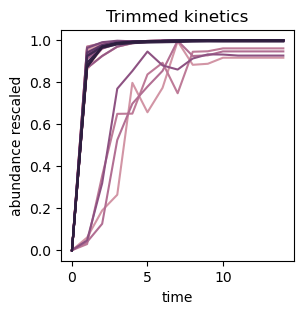

In [13]:
sns.lineplot(
    data=df3,
    x='time',
    y='abundance rescaled',
    estimator='mean',
    errorbar='sd',
    hue='cell id',
    legend=False,    
).set(title='Trimmed kinetics')

## Calculate the recovery rate

In [14]:
from htsimaging.bleach_chase.stat import get_scores
df4=df3.groupby('cell id').apply(get_scores).reset_index()
df4.head(1)

,cell id,variable,score,score SD
0,2,lag,0.1,0.092572


### Error in the estimates

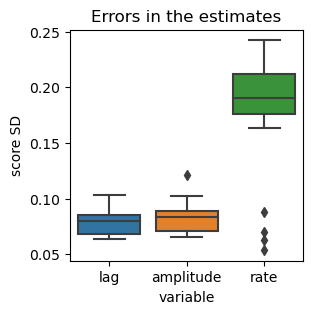

In [15]:
_=sns.boxplot(
    data=df4,
    x='variable',
    y='score SD',
).set(title="Errors in the estimates")

### Threshold on the error in estimates

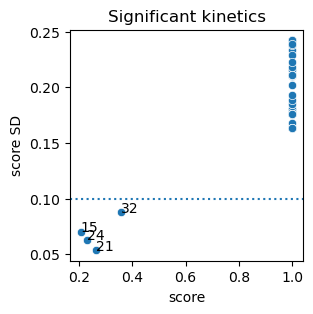

In [16]:
data=df4.query(expr="`variable` == 'rate'")
ax=sns.scatterplot(
    data=data,
    x='score',
    y='score SD',
)
ax.axhline(y=0.1,linestyle=":")
ax.set(title="Significant kinetics")
_=data.query(expr="`score SD` < 0.1").apply(lambda x: ax.text(x=x['score'],y=x['score SD'],s=x['cell id']),axis=1)

### Fitted curves

In [17]:
times=df3['time'].unique()
from htsimaging.bleach_chase.stat import exp1
df5=(df4
    .groupby('cell id')
        .apply(lambda df: dict(zip(times,exp1(x=times,**df.set_index('variable')['score'].to_dict()))))
        .apply(pd.Series)
    .melt(var_name='time',value_name='abundance fitted',ignore_index=False)
        .reset_index()
)
df5.head(1)

,cell id,time,abundance fitted
0,2,0,0.1


[Text(0.5, 1.0, 'Fitted kinetics')]

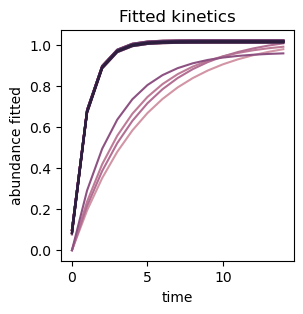

In [18]:
sns.lineplot(
    data=df5,
    x='time',
    y='abundance fitted',
    estimator='mean',
    errorbar='sd',
    hue='cell id',
    legend=False,
).set(title="Fitted kinetics")